In [5]:
# imports and loading
import sys
#sys.path.append('bitome2')
sys.path.append('/home/chris/github/Strainware-s/')
sys.path.append('/home/chris/github/Strainware-s/bitome2/')
import bitome
from bitome.core import Bitome
from workflows_CAD.feature_functions import *
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, LeaveOneOut, train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import copy
import random
import statistics
import math
import pickle
import logomaker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


bitome_genbank = Bitome('NC_000913.3.gb')
bitome_fasta = Bitome('NC_000913.3.fasta')
tu_table = pd.read_csv('tu.csv')
tf_pwm_db = rpwm('motif_pwm_db.txt')
tfbs = pd.read_csv('TFBS_regulondb.csv')

TF_flags_df = pd.read_csv('../data/TF_flags_expanded.csv', index_col = 0)

Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.


# Chris's work - gene to operon_motif_scores and logo plotting

In [6]:
# runs Archana's pipeline for all of our relevant genes
gene_to_operon_to_motif_scores_dist_to_TSS = {}
    
genes_test = TF_flags_df.TF
for gene in genes_test:
    gene = gene[0].upper()+gene[1:]
    if gene not in tf_pwm_db:
        continue
    gene_to_operon_to_motif_scores_dist_to_TSS.update({gene : {}})
    gene_pwm_old = tf_pwm_db[gene]
    gene_pssm = {base: [pos_dict[base] for pos_dict in gene_pwm_old] for base in 'ATCG'}

    # pull out data
    actual_val = []
    gene_rows = tfbs[[val.upper() == gene.upper() for val in tfbs['TF_name']]]
    left_end_positions = gene_rows['TF_bs_left_end_position'].tolist()
    right_end_positions = gene_rows['TF_bs_right_end_position'].tolist()
    for index, row in gene_rows.iterrows():
        name = row['Transcription_unit_name_regulated_by_TF']
        left = row['TF_bs_left_end_position']
        right = row['TF_bs_right_end_position']
        try:
            actual_val.append([name, int(left), int(right)])
        except:
            continue
    actual_df = pd.DataFrame(actual_val, columns=['name', 'left', 'right'])
    
    # tu_dict?
    tu = list(actual_df['name'])
    tu_dict = {item: tu.count(item) for item in tu}
    
    tu_table = pd.read_csv('tu.csv')
    tu_name=[]
    locus_tags = []
    score_gene=[]
    location_left =[]
    location_right = []
    matches = []
    for index, row in tu_table.iterrows():
        i = row['strand']
        j = row['tss']
        k = row['name']
        #i,j,k in zip(tu_table['strand'],tu_table['tss'],tu_table['name']):
        for m,n in (tu_dict.items()):
            if i == 1.0 and j.is_integer():
                if m==k:
                    #print(m)
                    tu_name.append([m] * n)  
                    locus_tags.append([row['locus_tag']] * n)
                    score_gene.append(bitome_fasta.motif_search(j-100, j+50, 1, gene_pssm, n_best_matches=n)['log_odds'].tolist())
                    location_left.append(bitome_fasta.motif_search(j-100, j+50, 1, gene_pssm, n_best_matches=n)['left'].tolist())
                    location_right.append(bitome_fasta.motif_search(j-100, j+50, 1, gene_pssm, n_best_matches=n)['right'].tolist())
                    matches.append(bitome_fasta.motif_search(j-100, j+50, 1, gene_pssm, n_best_matches=n)['match_sequence'].tolist())
            if i == -1.0 and j.is_integer():
                if m==k:
                    tu_name.append([m] * n)
                    locus_tags.append([row['locus_tag']] * n)
                    score_gene.append(bitome_fasta.motif_search(j-50, j+100, -1, gene_pssm, n_best_matches=n)['log_odds'].tolist())
                    location_left.append(bitome_fasta.motif_search(j-50, j+100, -1, gene_pssm, n_best_matches=n)['left'].tolist())
                    location_right.append(bitome_fasta.motif_search(j-50, j+100, -1, gene_pssm, n_best_matches=n)['right'].tolist())
                    matches.append(bitome_fasta.motif_search(j-100, j+50, 1, gene_pssm, n_best_matches=n)['match_sequence'].tolist())
            if not j.is_integer():
                if m==k:
                    tu_name.append([m] * 1)
                    locus_tags.append([row['locus_tag']] * 1)
                    score_gene.append([0])
                    location_left.append([0])
                    location_right.append([0])
                    matches.append([''])
                    
    tu_name_flat_list = [item for sublist in tu_name for item in sublist]
    score_gene_flat_list = [item for sublist in score_gene for item in sublist]
    location_left_flat_list = [item for sublist in location_left for item in sublist]
    location_right_flat_list = [item for sublist in location_right for item in sublist]
    matches_list = [item for sublist in matches for item in sublist]
    locus_tags = [item for sublist in locus_tags for item in sublist]

    data = {
        'TU': tu_name_flat_list,
        'locus_tag' : locus_tags,
        'Score': score_gene_flat_list,
        'Location_left': location_left_flat_list,
        'Location_right': location_right_flat_list,
        'Match_sequence' : matches_list,
    }
    predicted_df = pd.DataFrame(data)
    #predicted_df = predicted_df.drop([2, 3])
    predicted_df = predicted_df.reset_index(drop=True)
    predicted_df = predicted_df.drop_duplicates()
    
    for index, row in predicted_df.iterrows():
        if row['TU'] not in gene_to_operon_to_motif_scores_dist_to_TSS[gene]:
            gene_to_operon_to_motif_scores_dist_to_TSS[gene].update({row['TU'] : []})
        bby_TU = tu_table[tu_table['locus_tag'] == row['locus_tag']]
        if bby_TU['strand'].values[0] == -1:
            # aimed to the left, so TSS - motif
            dist_to_TSS = bby_TU['tss'].values[0] - ((row['Location_left'] + row['Location_right']) / 2)
        else:
            # aimed to the right, so motif - TSS
            dist_to_TSS = ((row['Location_left'] + row['Location_right']) / 2) - bby_TU['tss'].values[0]
        #dist_to_TSS = min([abs(bby_TU['tss'] - row['Location_left']).values[0], abs(bby_TU['tss'] - row['Location_right']).values[0]])
        next_val = (row['Score'], dist_to_TSS)
        gene_to_operon_to_motif_scores_dist_to_TSS[gene][row['TU']].append(next_val)

pickle_out = open('../data/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'wb')
pickle.dump(gene_to_operon_to_motif_scores_dist_to_TSS, pickle_out)
pickle_out.close()

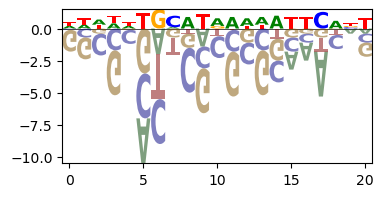

In [144]:
# plotting search motif
motif_df = pd.DataFrame(gene_pwm_old)
fig, ax = plt.subplots(1,1,figsize=[4, 2])
# create Logo object
logo = logomaker.Logo(motif_df, ax = ax,
                          shade_below=.5,
                          fade_below=.5,)
                          #font_name='Arial Rounded MT Bold')
plt.savefig('../figures/overall_logo.pdf', transparent = True)

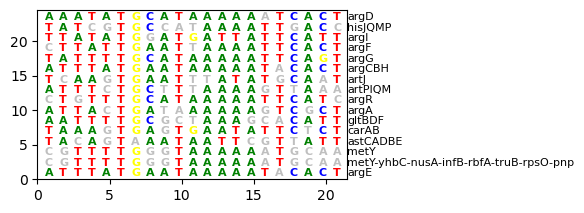

In [143]:
# plotting individual best matches
letter_to_color = {
    'T' : 'red',
    'A' : 'green',
    'G' : 'yellow',
    'C' : 'blue',
}
plt.figure(figsize = [4, 2.2])
y = .5
TUs_temp = list(predicted_df.TU)
TUs = []
_ = [TUs.append(x) for x in TUs_temp if x not in TUs]
for TU in TUs:
    bby = predicted_df[predicted_df['TU'] == TU].sort_values('Score').iloc[-1]
    for x in motif_df.index:
        good_letters = motif_df.columns[motif_df.loc[x] > 0].to_list()
        if bby.Match_sequence[x] in good_letters:
            color = letter_to_color[bby.Match_sequence[x]]
            alpha = 1
        else:
            color = 'grey'
            alpha = 0.5
        plt.text(y = y, x = x + .5, s = bby.Match_sequence[x], alpha = alpha, color = color, fontsize = 8, weight = 'bold')
    plt.text(y = y, x = len(bby.Match_sequence) + .5, fontsize = 8, s = TU)
    y += 1.5
plt.xlim([0, len(motif_df.index) + .5])
plt.ylim([0, y])
plt.savefig('../figures/motif_matches.pdf', transparent = True)
plt.show()

In [78]:
predicted_df

['A', 'T']

# Crp motif scores

In [14]:
tf_pwm_db = rpwm('motif_pwm_db.txt')
crp_pwm_old = tf_pwm_db['Crp']
crp_pssm = {base: [pos_dict[base] for pos_dict in crp_pwm_old] for base in 'ATCG'}

In [15]:
tfbs = pd.read_csv('TFBS_regulondb.csv')
actual_val = []
filter_values = ['sdhDAB', 'ptsG', 'aldA', 'manXYZ', 'cdd', 'galS', 'glpTQ', 'pck', 'raiAZ', 'mtlADR', 'idnDOTR']
for i in filter_values:
    desired_row = tfbs[tfbs['Transcription_unit_name_regulated_by_TF'] == i]
    crp_rows = desired_row[desired_row['TF_name'] == 'CRP']
    left_end_positions = crp_rows['TF_bs_left_end_position'].tolist()
    right_end_positions = crp_rows['TF_bs_right_end_position'].tolist()
    for left, right in zip(left_end_positions, right_end_positions):
        actual_val.append([i, int(left), int(right)])
actual_df = pd.DataFrame(actual_val, columns=['name', 'left', 'right'])
print(actual_df)

       name     left    right
0    sdhDAB   755380   755401
1      ptsG  1157661  1157682
2      ptsG  1157715  1157736
3      aldA  1488120  1488141
4    manXYZ  1901830  1901851
5    manXYZ  1901882  1901903
6       cdd  2231714  2231735
7       cdd  2231716  2231737
8       cdd  2231766  2231787
9       cdd  2231766  2231787
10     galS  2241742  2241763
11    glpTQ  2352482  2352503
12    glpTQ  2352532  2352553
13    glpTQ  2352572  2352593
14      pck  3532581  3532597
15      pck  3532684  3532700
16    raiAZ  2737076  2737092
17   mtlADR  3771916  3771937
18   mtlADR  3771958  3771979
19   mtlADR  3772002  3772023
20   mtlADR  3772075  3772096
21   mtlADR  3772119  3772140
22  idnDOTR  4494466  4494488
23  idnDOTR  4494516  4494537


In [65]:
tu = list(actual_df['name'])
tu_dict = {item: tu.count(item) for item in tu}

In [66]:
tu_table = pd.read_csv('tu.csv')
import math
tu_name=[]
score_crp=[]
location_left =[]
location_right = []
for i,j,k in zip(tu_table['strand'],tu_table['tss'],tu_table['name']):
    for m,n in (tu_dict.items()):
        if i == 1.0 and j.is_integer():
            if m==k:
                #print(m)
                tu_name.append([m] * n)       
                score_crp.append(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=n)['log_odds'].tolist())
                location_left.append(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=n)['left'].tolist())
                location_right.append(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=n)['right'].tolist())
        if i == -1.0 and j.is_integer():
            if m==k:
                tu_name.append([m] * n) 
                score_crp.append(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=n)['log_odds'].tolist())
                location_left.append(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=n)['left'].tolist())
                location_right.append(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=n)['right'].tolist())
        if not j.is_integer():
            if m==k:
                tu_name.append([m] * n) 
                score_crp.append(0)
                location_left.append(0)
                location_right.append(0)

In [67]:
tu_name_flat_list = [item for sublist in tu_name for item in sublist]
score_crp_flat_list = [item for sublist in score_crp for item in sublist]
location_left_flat_list = [item for sublist in location_left for item in sublist]
location_right_flat_list = [item for sublist in location_right for item in sublist]

data = {
    'TU': tu_name_flat_list,
    'Score': score_crp_flat_list,
    'Location_left': location_left_flat_list,
    'Location_right': location_right_flat_list
}
predicted_df = pd.DataFrame(data)
predicted_df = predicted_df.drop([2, 3])
predicted_df = predicted_df.reset_index(drop=True)
print(predicted_df)

TypeError: 'int' object is not iterable

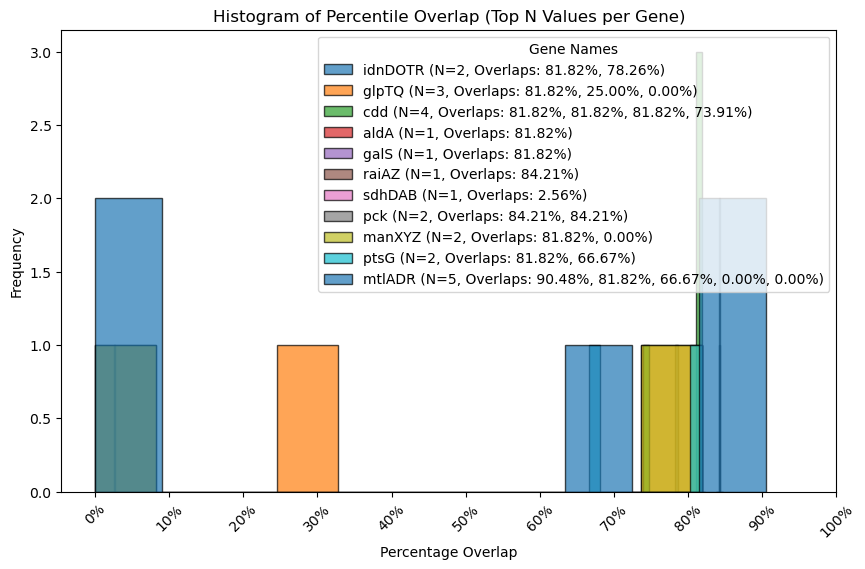

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


overlap_percentages = []
gene_names = []


gene_count = {}

for _, actual_row in actual_df.iterrows():
    actual_gene = actual_row['name']
    actual_left, actual_right = actual_row['left'], actual_row['right']

    # Increase the count for the gene
    gene_count[actual_gene] = gene_count.get(actual_gene, 0) + 1
    
    for _, predicted_row in predicted_df.iterrows():
        predicted_gene = predicted_row['TU']
        
        if actual_gene == predicted_gene and gene_count[actual_gene] <= gene_count.get(actual_gene, 0):  # Include top N values
            predicted_left, predicted_right = predicted_row['Location_left'], predicted_row['Location_right']

            intersection = max(0, min(actual_right, predicted_right) - max(actual_left, predicted_left))
            union = max(actual_right, predicted_right) - min(actual_left, predicted_left)

            overlap_percentage = (intersection / union) * 100
            overlap_percentages.append(overlap_percentage)
            gene_names.append(actual_gene)


plt.figure(figsize=(10, 6))
legend_labels = {}

cmap = plt.get_cmap('tab20')

unique_genes = list(set(gene_names))
colors = cmap(np.linspace(0, 1, len(unique_genes)))

for i, gene in enumerate(unique_genes):
    gene_overlap = [overlap_percentages[j] for j in range(len(overlap_percentages)) if gene_names[j] == gene]
    top_n = gene_count[gene]
    top_values = sorted(gene_overlap, reverse=True)[:top_n]
    label = f"{gene} (N={top_n}, Overlaps: {', '.join([f'{overlap:.2f}%' for overlap in top_values])})"
    
    plt.hist(top_values, bins=10, edgecolor='black', alpha=0.7, label=label)

plt.xlabel('Percentage Overlap')
plt.ylabel('Frequency')
plt.title('Histogram of Percentile Overlap (Top N Values per Gene)')
plt.xticks(range(0, 101, 10))
plt.xticks(rotation=45)
plt.xticks(range(0, 101, 10), [str(i) + '%' for i in range(0, 101, 10)])

# Add a legend
plt.legend(title='Gene Names', loc='upper right')

plt.show()


# Clean Code

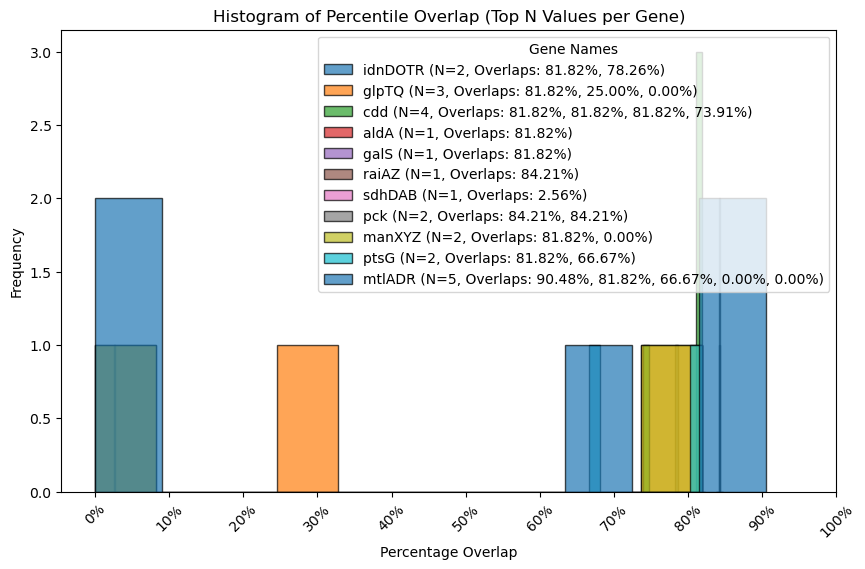

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_actual_data(file_path):
    filter_values = ['sdhDAB', 'ptsG', 'aldA', 'manXYZ', 'cdd', 'galS', 'glpTQ', 'pck', 'raiAZ', 'mtlADR', 'idnDOTR']
    tf_name = 'CRP'
    tfbs = pd.read_csv(file_path)
    actual_val = []
    for i in filter_values:
        desired_row = tfbs[tfbs['Transcription_unit_name_regulated_by_TF'] == i]
        crp_rows = desired_row[desired_row['TF_name'] == tf_name]
        left_end_positions = crp_rows['TF_bs_left_end_position'].tolist()
        right_end_positions = crp_rows['TF_bs_right_end_position'].tolist()
        for left, right in zip(left_end_positions, right_end_positions):
            actual_val.append([i, int(left), int(right)])

    actual_df = pd.DataFrame(actual_val, columns=['name', 'left', 'right'])
    tu = list(actual_df['name'])
    tu_dict = {item: tu.count(item) for item in tu}
    
    return actual_df

def load_predicted_data(tu_table, tu_dict, crp_pssm):
    tu_name = []
    score_crp = []
    location_left = []
    location_right = []

    for i,j,k in zip(tu_table['strand'],tu_table['tss'],tu_table['name']):
        for m,n in (tu_dict.items()):
            if i == 1.0 and j.is_integer():
                if m==k:
                    tu_name.append([m] * n)       
                    score_crp.append(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=n)['log_odds'].tolist())
                    location_left.append(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=n)['left'].tolist())
                    location_right.append(bitome_fasta.motif_search(j-100, j+50, 1, crp_pssm, n_best_matches=n)['right'].tolist())
            if i == -1.0 and j.is_integer():
                if m==k:
                    tu_name.append([m] * n) 
                    score_crp.append(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=n)['log_odds'].tolist())
                    location_left.append(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=n)['left'].tolist())
                    location_right.append(bitome_fasta.motif_search(j-50, j+100, -1, crp_pssm, n_best_matches=n)['right'].tolist())
            if not j.is_integer():
                if m==k:
                    tu_name.append([m] * n) 
                    score_crp.append(0)
                    location_left.append(0)
                    location_right.append(0)

    data = {
        'TU': [item for sublist in tu_name for item in sublist],
        'Score': [item for sublist in score_crp for item in sublist],
        'Location_left': [item for sublist in location_left for item in sublist],
        'Location_right': [item for sublist in location_right for item in sublist]
    }

    predicted_df = pd.DataFrame(data)
    predicted_df = predicted_df.drop([2, 3])
    predicted_df = predicted_df.reset_index(drop=True)
    
    return predicted_df


def calculate_overlap_percentages(actual_df, predicted_df):
    overlap_percentages = []
    gene_names = []

    gene_count = {}

    for _, actual_row in actual_df.iterrows():
        actual_gene = actual_row['name']
        actual_left, actual_right = actual_row['left'], actual_row['right']

        gene_count[actual_gene] = gene_count.get(actual_gene, 0) + 1

        for _, predicted_row in predicted_df.iterrows():
            predicted_gene = predicted_row['TU']

            if actual_gene == predicted_gene and gene_count[actual_gene] <= gene_count.get(actual_gene, 0):
                predicted_left, predicted_right = predicted_row['Location_left'], predicted_row['Location_right']

                intersection = max(0, min(actual_right, predicted_right) - max(actual_left, predicted_left))
                union = max(actual_right, predicted_right) - min(actual_left, predicted_left)

                overlap_percentage = (intersection / union) * 100
                overlap_percentages.append(overlap_percentage)
                gene_names.append(actual_gene)

    return overlap_percentages, gene_names, gene_count


def generate_histogram(overlap_percentages, gene_names, gene_count):
    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap('tab20')

    unique_genes = list(set(gene_names))
    colors = cmap(np.linspace(0, 1, len(unique_genes)))

    for i, gene in enumerate(unique_genes):
        gene_overlap = [overlap_percentages[j] for j in range(len(overlap_percentages)) if gene_names[j] == gene]

        top_n = gene_count[gene]
        top_values = sorted(gene_overlap, reverse=True)[:top_n]

        label = f"{gene} (N={top_n}, Overlaps: {', '.join([f'{overlap:.2f}%' for overlap in top_values])})"

        plt.hist(top_values, bins=10, edgecolor='black', alpha=0.7, label=label)

    plt.xlabel('Percentage Overlap')
    plt.ylabel('Frequency')
    plt.title('Histogram of Percentile Overlap (Top N Values per Gene)')
    plt.xticks(range(0, 101, 10))
    plt.xticks(rotation=45)
    plt.xticks(range(0, 101, 10), [str(i) + '%' for i in range(0, 101, 10)])
    plt.legend(title='Gene Names', loc='upper right')
    plt.show()

if __name__ == '__main__':

    actual_df = load_actual_data('TFBS_regulondb.csv')
    tu_table = pd.read_csv('tu.csv')
    tf_pwm_db = rpwm('motif_pwm_db.txt')
    crp_pwm_old = tf_pwm_db['Crp']
    crp_pssm = {base: [pos_dict[base] for pos_dict in crp_pwm_old] for base in 'ATCG'}
    predicted_df = load_predicted_data(tu_table, tu_dict, crp_pssm)
    overlap_percentages, gene_names, gene_count = calculate_overlap_percentages(actual_df, predicted_df)
    generate_histogram(overlap_percentages, gene_names, gene_count)
